In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.collections import PatchCollection
import glob
import copy
import autorank
import os
from pathlib import Path

from nvita.utils import open_json
from nvita.attacks.utils import (append_result_to_csv_file,
                                 check_result_file_path,
                                 create_empty_result_csv_file)

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_ROOT = Path(os.getcwd()).parent.absolute()
PATH_NTRE = os.path.join(PATH_ROOT, "results", "non_targeted_results")
PATH_TARE = os.path.join(PATH_ROOT, "results", "targeted_results")
PATH_EXPS = os.path.join(PATH_ROOT, "experiments")

In [3]:
my_metadata = open_json(os.path.join(
    PATH_ROOT, "experiments", "metadata.json"))
print(my_metadata)

{'data': ['Electricity', 'NZTemp', 'CNYExch', 'Oil'], 'seeds': ['2210', '9999', '58361', '789789', '1111111'], 'y_col_name': ['Consumption', 'Auckland', 'Close', 'Close'], 'window_size': ['4', '3', '7', '7'], 'models': ['CNN', 'LSTM', 'GRU', 'RF'], 'attacks': ['NOATTACK', 'BRS', 'BRNV', 'FGSM', 'BIM', 'NVITA', 'FULLVITA'], 'n_values': [1, 3, 5], 'epsilons': [0.05, 0.1, 0.15, 0.2], 'targets': ['Positive', 'Negative']}


In [4]:
class RequiredCSV:
    """
    Required CSV class
    """
    def __init__(self, df_name = None, seed = None, eps = None, model = None, attack = None, targeted = False, target_direction = None, count = 0):
        self.df_name = df_name
        self.seed = seed
        self.eps = eps
        self.model = model
        self.attack = attack
        self.targeted = targeted
        self.target_direction = target_direction
        self.count = count
        self.all_paths = []
        # all_names list is used to check duplications
    def get_output_line_list(self):
        if self.targeted:
            return [self.df_name, self.seed, self.eps, self.model, self.attack, self.target_direction, self.count, str(self)]
        else:
            return [self.df_name, self.seed, self.eps, self.model, self.attack, self.count, str(self)]
        
    def __str__(self) -> str:
        if self.targeted:
            return "df_"+self.df_name+"_seed_"+str(self.seed)+"_model_"+self.model+"_epsilon_"+str(self.eps)+"_attack_"+self.attack+"_target_"+self.target_direction
        else:
            return "df_"+self.df_name+"_seed_"+str(self.seed)+"_model_"+self.model+"_epsilon_"+str(self.eps)+"_attack_"+self.attack

## Non-targeted Check

In [5]:
nont_d = {}
total_count = 0
for df in my_metadata["data"]:
    for seed in my_metadata["seeds"]:
        for eps in my_metadata["epsilons"]:
            for model in my_metadata["models"]:
                if model == "RF":
                    attacks = ["NOATTACK", "BRS", "Non_Targeted_BR5V", "Non_Targeted_1VITA", "Non_Targeted_3VITA", "Non_Targeted_5VITA", "FULLVITA"]
                else:
                    attacks = ["NOATTACK", "BRS", "Non_Targeted_BR5V", "FGSM", "BIM", "Non_Targeted_1VITA", "Non_Targeted_3VITA", "Non_Targeted_5VITA", "FULLVITA"]
                for attack in attacks:
                    rcsv = RequiredCSV(df, seed, eps, model, attack)
                    total_count += 1
                    nont_d[str(rcsv)] = rcsv
print("Total number of csv result files for non-targeted experiments are " + str(total_count))

Total number of csv result files for non-targeted experiments are 2720


In [6]:
for (root,dirs,files) in os.walk(PATH_NTRE, topdown=True):
    for file in (f for f in files if f.endswith(".csv")):
        file_path = Path(root, file)
        df = pd.read_csv(file_path, index_col=None, header=0)
        if df.shape[0] == 100:
            # Complete result
            suffix_ind = -5
            while file[suffix_ind] == "1":
                suffix_ind -= 1
            nont_d[file[:suffix_ind+1]].count+=1
            nont_d[file[:suffix_ind+1]].all_paths.append(file_path)
            # Append the existing file name, it can be modified to remove duplication

# Plot: Comparison Non-Targeted Attacks

In [7]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap.from_list("", ["lightskyblue","blue"])
cmap_whiteblue = colors.LinearSegmentedColormap.from_list("", ["white","blue"])
cdict = {"1VITA": cmap(0.1),
         "3VITA": cmap(0.45),
         "5VITA": cmap(0.70),
         "fullVITA": cmap(0.99),#"#d7af00",
         "FGSM": "#CC6677",
         "BIM": "#882255",
         "BR5V": "#EECC66",#"#00ff5f",
         "BRS": "#d7af00",#"#00af87",
         "BR5": "#00875f",
         "RFGSM": "#117733",
         "BPM": "#999CC77",
         "BR": "#44AA99",
         "No Attack": "darkgrey"}
all_d_names = ["Electricity", "NZTemp","CNYExch", "Oil"]
order_nont_anns = ["No Attack", "BR5V", "BRS", "1VITA", "3VITA", "5VITA", "fullVITA", "FGSM", "BIM"]

#### Read non-targeted results
Not all non-targeted expereimets are completed

In [8]:
li = []
result_count = 0
for r in nont_d:
    curr_exp = nont_d[r]
    if curr_exp.count >= 1:
        # if the valid csv file is larger than 1
        file_path = curr_exp.all_paths[0]
        # read the first valid result csv
        df = pd.read_csv(file_path, index_col=None, header=0)
        li.append(df)
        result_count+=1

df_nont = pd.concat(li, axis=0, ignore_index=True)
print("Total number of csv result files for non-targeted experiments are 2720")
print("We currently have", result_count)

Total number of csv result files for non-targeted experiments are 2720
We currently have 2720


In [9]:
df_nont

,df,Seed,Model,Epsilon,Targeted,Test Index,Attack Name,True y,Original y Pred,Attacked y Pred,Attacked AE,Original AE,Max Per,Sum Per,Cost Time,Window Range,Adv Example,Unnamed: 17
0,Electricity,2210,CNN,0.05,False,0,NOATTACK,0.672584,0.562173,0.562267,0.110410,0.110316,0.000000,0.000000,0.000001,[0.04901205003261566; 0.08901553601026535; 0.4...,[[[0.6418231129646301; 0.12937945127487183; 0....,NaN
1,Electricity,2210,CNN,0.05,False,1,NOATTACK,0.910354,0.783120,0.783135,0.127233,0.127219,0.000000,0.000000,0.000002,[0.44276919960975647; 0.14444103837013245; 0.0...,[[[0.9424374103546143; 0.06804738193750381; 0....,NaN
2,Electricity,2210,CNN,0.05,False,2,NOATTACK,0.245824,0.248524,0.248623,0.002700,0.002799,0.000000,0.000000,0.000002,[0.29896682500839233; 0.2935175597667694; 0.15...,[[[0.6672875285148621; 0.4920886158943176; 0.3...,NaN
3,Electricity,2210,CNN,0.05,False,3,NOATTACK,0.891482,0.885630,0.885629,0.005852,0.005853,0.000000,0.000000,0.000003,[0.4450129568576813; 0.3348195254802704; 0.010...,[[[0.5957567095756531; 0.4335622191429138; 0.1...,NaN
4,Electricity,2210,CNN,0.05,False,4,NOATTACK,0.857214,0.718997,0.718889,0.138217,0.138325,0.000000,0.000000,0.000002,[0.021519480273127556; 0.38747474551200867; 0....,[[[0.8583270907402039; 0.7205108404159546; 0.0...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271995,Oil,1111111,RF,0.20,False,95,Non-targeted_fullVITA,0.212712,0.204908,0.209520,0.007804,0.003192,0.002892,0.054818,83.213634,[0.013556988909840584; 0.013588211499154568; 0...,[[[0.20008809864521027; 0.19622887670993805; 0...,NaN
271996,Oil,1111111,RF,0.20,False,96,Non-targeted_fullVITA,0.210418,0.218655,0.215679,0.008238,0.005262,0.001576,0.033144,70.966564,[0.007812503725290298; 0.008060810156166553; 0...,[[[0.2087525725364685; 0.20448164641857147; 0....,NaN
271997,Oil,1111111,RF,0.20,False,97,Non-targeted_fullVITA,0.859339,0.844805,0.850665,0.014535,0.008674,0.004898,0.074796,64.839766,[0.021139662712812424; 0.02118835039436817; 0....,[[[0.8630433678627014; 0.8570792078971863; 0.8...,NaN
271998,Oil,1111111,RF,0.20,False,98,Non-targeted_fullVITA,0.753327,0.775067,0.750787,0.021739,0.002540,0.006182,0.095866,40.785414,[0.03331803157925606; 0.033394765108823776; 0....,[[[0.7701444029808044; 0.7673375010490417; 0.7...,NaN


In [10]:
df_nont = df_nont[['df','Seed', 'Model','Epsilon', 'Test Index','Attack Name', 'Attacked AE', 'Max Per', 'Sum Per', 'Cost Time']]
df_nont.rename(columns = {'Max Per':'Max Perturbation', 'Sum Per':'Total Perturbation'}, inplace = True)
df_nont['Attack Name'] = df_nont['Attack Name'].map(
    {'NOATTACK': 'No Attack', 'Non-targeted_1VITA': '1VITA', 'Non-targeted_3VITA': '3VITA','Non-targeted_5VITA': '5VITA','Non-targeted_fullVITA': 'fullVITA','Non-targeted_FGSM': 'FGSM','Non-targeted_BIM': 'BIM','Non-targeted_BR5V':'BR5V','Non-targeted_BRS':'BRS'})

C:\Users\markc\AppData\Local\Temp\ipykernel_15536\1676046622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nont.rename(columns = {'Max Per':'Max Perturbation', 'Sum Per':'Total Perturbation'}, inplace = True)
C:\Users\markc\AppData\Local\Temp\ipykernel_15536\1676046622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nont['Attack Name'] = df_nont['Attack Name'].map(


In [11]:
df_nont_all4 = df_nont[['df','Seed', 'Model','Epsilon', 'Test Index','Attack Name', 'Attacked AE', 'Max Perturbation', 'Total Perturbation', 'Cost Time']].copy()

In [12]:
df_nont_anns = df_nont_all4[df_nont_all4['Model'] != "RF"]

In [13]:
df_nont_anns_grouped = df_nont_anns.groupby(['df', 'Model', 'Attack Name', 'Epsilon'], as_index=False)
df_nont_anns_grouped = df_nont_anns_grouped.agg(
    {'Total Perturbation':'mean', 'Max Perturbation':'mean', 'Attacked AE':'mean'})

In [14]:
df_nont_anns_grouped

,df,Model,Attack Name,Epsilon,Total Perturbation,Max Perturbation,Attacked AE
0,CNYExch,CNN,1VITA,0.05,0.000916,0.000916,0.010545
1,CNYExch,CNN,1VITA,0.10,0.002322,0.002322,0.010780
2,CNYExch,CNN,1VITA,0.15,0.003857,0.003857,0.011082
3,CNYExch,CNN,1VITA,0.20,0.005418,0.005418,0.011346
4,CNYExch,CNN,3VITA,0.05,0.002461,0.001191,0.010663
...,...,...,...,...,...,...,...
427,Oil,LSTM,No Attack,0.20,0.000000,0.000000,0.008445
428,Oil,LSTM,fullVITA,0.05,0.030076,0.002889,0.008780
429,Oil,LSTM,fullVITA,0.10,0.063020,0.005888,0.009557
430,Oil,LSTM,fullVITA,0.15,0.095904,0.009004,0.010497


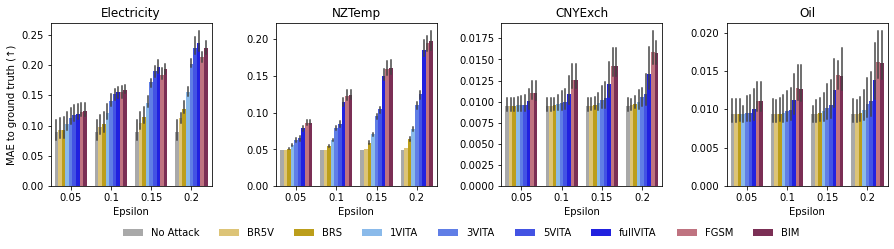

In [15]:
import matplotlib.ticker as mtick
f, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=False)
for i, ds in enumerate(all_d_names):
    g = sns.barplot(palette=cdict, hue_order=order_nont_anns, ax=ax[i], errwidth=1.5,
                 data=df_nont_anns_grouped.loc[df_nont_anns_grouped['df'] == ds], hue='Attack Name', y='Attacked AE', x='Epsilon')
    g.legend_.remove()
    #g.set(xlabel=None, xticks=[])
    g.set(ylabel="MAE to ground truth (↑)")
    g.set(title=ds)
    if i==2:
        g.legend(loc='upper center', bbox_to_anchor=(-0.25, -0.2), frameon=False, ncol=9)
    if i>0:
        g.set(ylabel=None)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.savefig('nont_epsilon_vs_MAE_group_by_dataset.pdf', bbox_inches='tight')

#### Reverse the Sign of the AE

In [16]:
df_nont_anns_grouped_rev = copy.deepcopy(df_nont_anns_grouped)
df_nont_anns_grouped_rev['Attacked AE'] = -df_nont_anns_grouped_rev['Attacked AE']

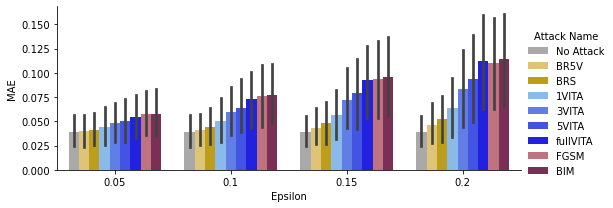

In [17]:
sns.catplot(data=df_nont_anns_grouped, kind='bar', height=3, aspect=2.5, palette=cdict, hue_order=order_nont_anns,
               hue='Attack Name', y='Attacked AE', x='Epsilon', ci=90)
plt.ylabel("MAE")
plt.savefig('nont_epsilon_vs_MAE.pdf', bbox_inches='tight')

sns.catplot(data=df_grouped, kind='bar', height=2, aspect=4, row='Dataset', palette=cdict, hue_order=order_nont, sharey=False,
               hue='Attack', y='AE', x='Epsilon')

sns.catplot(data=df_grouped, kind='bar', height=2, aspect=4, row='Model', palette=cdict, hue_order=order_nont, sharey=False,
               hue='Attack', y='AE', x='Epsilon')

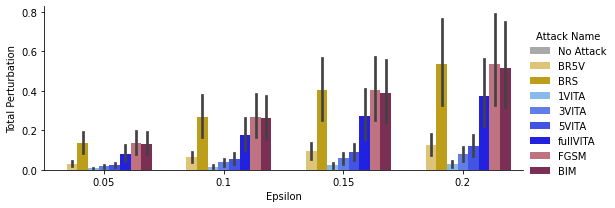

In [18]:
sns.catplot(data=df_nont_anns_grouped, kind='bar', height=3, aspect=2.5, palette=cdict, hue_order=order_nont_anns,
               hue='Attack Name', y='Total Perturbation', x='Epsilon')
plt.savefig('nont_epsilon_vs_total_perturbation.pdf', bbox_inches='tight')

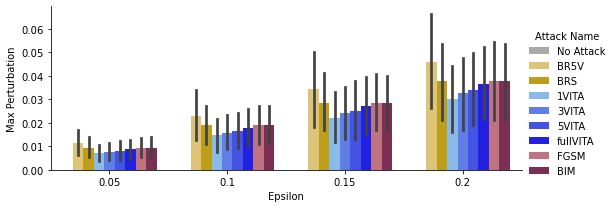

In [19]:
sns.catplot(data=df_nont_anns_grouped, kind='bar', height=3, aspect=2.5, palette=cdict, hue_order=order_nont_anns,
               hue='Attack Name', y='Max Perturbation', x='Epsilon')
plt.savefig('nont_epsilon_vs_maximum_perturbation.pdf', bbox_inches='tight')

## Non-T CD plots

In [20]:
nont_df_g = copy.deepcopy(df_nont_anns)[['df','Seed', 'Model', 'Test Index','Attack Name', 'Epsilon', 'Attacked AE']]
nont_df_g.columns = ['Dataset','Seed', 'Model', 'Window Index', 'Attack', 'Epsilon', 'AE']
nont_df_g['AE'] = -nont_df_g['AE']
nont_df_g.isnull().values.any() 

False

In [21]:
nont_df_g

,Dataset,Seed,Model,Window Index,Attack,Epsilon,AE
0,Electricity,2210,CNN,0,No Attack,0.05,-0.110410
1,Electricity,2210,CNN,1,No Attack,0.05,-0.127233
2,Electricity,2210,CNN,2,No Attack,0.05,-0.002700
3,Electricity,2210,CNN,3,No Attack,0.05,-0.005852
4,Electricity,2210,CNN,4,No Attack,0.05,-0.138217
...,...,...,...,...,...,...,...
271295,Oil,1111111,GRU,95,fullVITA,0.20,-0.007499
271296,Oil,1111111,GRU,96,fullVITA,0.20,-0.004008
271297,Oil,1111111,GRU,97,fullVITA,0.20,-0.005285
271298,Oil,1111111,GRU,98,fullVITA,0.20,-0.008967


In [22]:
nont_df_g_all = copy.deepcopy(nont_df_g)

nont_df_g_all = nont_df_g_all.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index'], 
        columns="Attack",
        values="AE")
nont_df_g_all.isnull().values.any() 

False

In [23]:
untargeted_result_all = autorank.autorank(nont_df_g_all, alpha=0.05, verbose=False, order='ascending')
print(untargeted_result_all)

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


RankResult(rankdf=
           meanrank    median       mad  ci_lower  ci_upper effect_size  \
Attack                                                                    
BIM        1.588792 -0.041301  0.037038 -0.046904 -0.036744         0.0   
FGSM       1.809792 -0.040100  0.035775  -0.04545 -0.035809   -0.022245   
fullVITA   3.365333 -0.037443  0.034452 -0.042492 -0.033228   -0.072747   
5VITA      4.785500 -0.031231  0.028811 -0.034558  -0.02757   -0.204695   
3VITA      5.442042 -0.029417  0.026974 -0.032806 -0.026341   -0.247392   
1VITA      6.430417 -0.024329  0.021668 -0.026275 -0.022475    -0.37728   
BRS        6.801833 -0.017487   0.01504 -0.018639 -0.016431    -0.56823   
BR5V       7.250250 -0.015928   0.01336 -0.016934 -0.015147   -0.614684   
No Attack  7.526042 -0.015090  0.012404 -0.015844 -0.014315   -0.640079   

            magnitude  
Attack                 
BIM        negligible  
FGSM       negligible  
fullVITA   negligible  
5VITA           small  
3VITA      

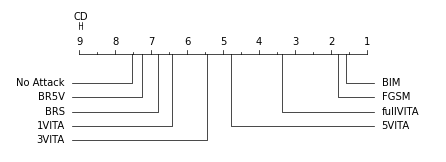

In [24]:
autorank.plot_stats(untargeted_result_all)
#plt.title("the CD Diagram of the Untargeted Attack (All)")
plt.savefig("nont_cd_all.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


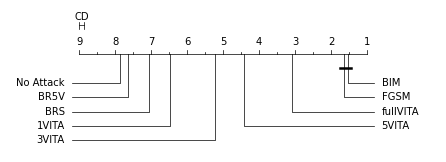

In [25]:
nont_df_g_cnn = copy.deepcopy(nont_df_g).loc[nont_df_g['Model'] == "CNN"]

nont_df_g_cnn = nont_df_g_cnn.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index'], 
        columns="Attack",
        values="AE")
print(nont_df_g_cnn.isnull().values.any())
untargeted_result_cnn = autorank.autorank(nont_df_g_cnn, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(untargeted_result_cnn)
#plt.title("the CD Diagram of the Untargeted Attack (All)")
plt.savefig("nont_cd_cnn.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


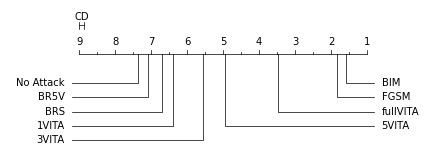

In [26]:
nont_df_g_lstm = copy.deepcopy(nont_df_g).loc[nont_df_g['Model'] == "LSTM"]

nont_df_g_lstm = nont_df_g_lstm.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index'], 
        columns="Attack",
        values="AE")
print(nont_df_g_lstm.isnull().values.any())
untargeted_result_lstm = autorank.autorank(nont_df_g_lstm, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(untargeted_result_lstm)
#plt.title("the CD Diagram of the Untargeted Attack (All)")
plt.savefig("nont_cd_lstm.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


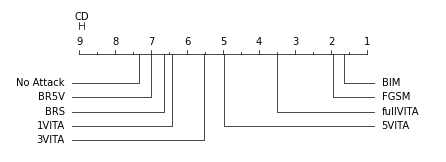

In [27]:
nont_df_g_gru = copy.deepcopy(nont_df_g).loc[nont_df_g['Model'] == "GRU"]

nont_df_g_gru = nont_df_g_gru.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index'], 
        columns="Attack",
        values="AE")
print(nont_df_g_gru.isnull().values.any())
untargeted_result_gru = autorank.autorank(nont_df_g_gru, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(untargeted_result_gru)
#plt.title("the CD Diagram of the Untargeted Attack (All)")
plt.savefig("nont_cd_gru.pdf", bbox_inches='tight')
plt.show()

In [28]:
nont_df_g_models = copy.deepcopy(nont_df_g)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == 'BRS'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == 'BR5V'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == '1VITA'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == '3VITA'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == '5VITA'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == 'FGSM'].index)
nont_df_g_models = nont_df_g_models.drop(nont_df_g_models[nont_df_g_models.Attack == 'No Attack'].index)
nont_df_g_models = nont_df_g_models.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index'], 
        columns="Attack",
        values="AE")
nont_df_g_models.isnull().values.any() 

False

In [29]:
untargeted_result_models = autorank.autorank(nont_df_g_models, alpha=0.05, verbose=False, order='ascending')
print(untargeted_result_models)

RankResult(rankdf=
          meanrank    median       mad  ci_lower  ci_upper effect_size  \
Attack                                                                   
BIM       1.038833 -0.041301  0.037038 -0.045976  -0.03752         0.0   
fullVITA  1.961167 -0.037443  0.034452 -0.041612 -0.034102   -0.072747   

           magnitude  
Attack                
BIM       negligible  
fullVITA  negligible  
pvalue=0.0
cd=None
omnibus=wilcoxon
posthoc=None
all_normal=False
pvals_shapiro=[0.0, 0.0]
homoscedastic=True
pval_homogeneity=0.05861966041462649
homogeneity_test=levene
alpha=0.05
alpha_normality=0.025
num_samples=24000
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [30]:
autorank.plot_stats(untargeted_result_models)
plt.savefig("nont_cd_model.pdf", bbox_inches='tight')
plt.show()

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\autorank\autorank.py:333: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')


<Figure size 432x288 with 0 Axes>

### Non-targeted with Random Forest

In [31]:
df_nont_all4_no_base = df_nont_all4[df_nont_all4["Attack Name"].isin(order_nont_anns[3:])]
df_nont_all4_no_base['Attacked AE'] = -df_nont_all4_no_base['Attacked AE']
# Get -AE to keep consistency with targeted

df_nont_all4_no_base_grouped = df_nont_all4_no_base.groupby(['df', 'Model', 'Attack Name', 'Epsilon'], as_index=False)

df_nont_all4_no_base_grouped = df_nont_all4_no_base_grouped.agg(
    {'Total Perturbation':'mean', 'Max Perturbation':'mean', 'Attacked AE':'mean'})
#df_grouped = df_grouped[~df_grouped['Attack Name'].isin(['RFGSM', 'BPM', 'BNM'])]

C:\Users\markc\AppData\Local\Temp\ipykernel_15536\2220227857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nont_all4_no_base['Attacked AE'] = -df_nont_all4_no_base['Attacked AE']


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

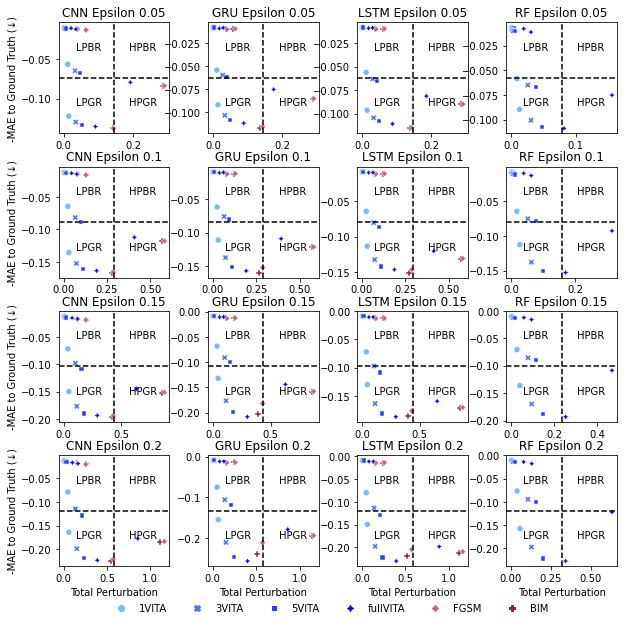

In [32]:
f, ax = plt.subplots(4, 4, figsize=(10, 10), sharey=False, sharex=False)
for i, m in enumerate(df_nont_all4_no_base_grouped['Epsilon'].unique()):
    df_models = df_nont_all4_no_base_grouped.loc[df_nont_all4_no_base_grouped['Epsilon'] == m].copy()
                            
    for j, n in enumerate(df_nont_all4_no_base_grouped['Model'].unique()):
        df = df_models.loc[df_models['Model'] == n].copy()
        g = sns.scatterplot(palette=cdict, hue_order=order_nont_anns[3:], ax=ax[i, j], 
                            data=df, x='Total Perturbation', y='Attacked AE', hue='Attack Name', style="Attack Name", style_order=df_nont_all4_no_base_grouped['Attack Name'].unique().tolist())
        
        x_range = g.get_xlim()[1] - g.get_xlim()[0]
        y_range = g.get_ylim()[1] - g.get_ylim()[0]

        g.axvline(x=g.get_xlim()[0]+x_range/2, color="black", linestyle="--")
        g.axhline(y=g.get_ylim()[0]+y_range/2, color="black", linestyle="--")
        g.text(g.get_xlim()[0]+0.6*x_range/4, g.get_ylim()[0]+y_range/4, "LPGR", fontsize=10)
        g.text(g.get_xlim()[1]-1.45*x_range/4, g.get_ylim()[0]+y_range/4, "HPGR", fontsize=10)
        g.text(g.get_xlim()[0]+0.6*x_range/4, g.get_ylim()[1]-y_range/4, "LPBR", fontsize=10)
        g.text(g.get_xlim()[1]-1.45*x_range/4, g.get_ylim()[1]-y_range/4, "HPBR", fontsize=10)
        
        if i!=3: g.set(xlabel=None)
        g.set(title=str(n)+" Epsilon "+str(m))
        if j==0: 
            g.set(ylabel="-MAE to Ground Truth (↓)")
        else:
            g.set(ylabel=None)
        if i==3 and j==1: 
            g.legend(loc='upper center', bbox_to_anchor=(1.1, -0.25), frameon=False, ncol=8)
        else:
            g.legend_.remove()
            
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.3)
plt.savefig('non_total_perturbation_vs_MAE_group_by_epsilon_and_model.pdf', bbox_inches='tight')

## targeted Check

In [33]:
t_d = {}
total_count = 0
for df in my_metadata["data"]:
    for seed in my_metadata["seeds"]:
        for eps in my_metadata["epsilons"]:
            for td in my_metadata["targets"]:
                for model in my_metadata["models"]:
                    if model == "RF":
                        attacks = ["NOATTACK", "BRS", "Targeted_BR5V", "Targeted_1VITA", "Targeted_3VITA", "Targeted_5VITA", "FULLVITA"]
                    else:
                        attacks = ["NOATTACK", "BRS", "Targeted_BR5V", "FGSM", "BIM", "Targeted_1VITA", "Targeted_3VITA", "Targeted_5VITA", "FULLVITA"]
                    for attack in attacks:
                        rcsv = RequiredCSV(df, seed, eps, model, attack, True, td)
                        total_count += 1
                        t_d[str(rcsv)] = rcsv
print("Total number of csv result files for targeted experiments are " + str(total_count))

Total number of csv result files for targeted experiments are 5440


In [34]:
df_nont_all4_no_base

,df,Seed,Model,Epsilon,Test Index,Attack Name,Attacked AE,Max Perturbation,Total Perturbation,Cost Time
300,Electricity,2210,CNN,0.05,0,FGSM,-0.119490,0.022500,0.117606,0.018489
301,Electricity,2210,CNN,0.05,1,FGSM,-0.212591,0.022138,0.121702,0.004023
302,Electricity,2210,CNN,0.05,2,FGSM,-0.044431,0.014948,0.149579,0.003622
303,Electricity,2210,CNN,0.05,3,FGSM,-0.064609,0.022251,0.158120,0.003808
304,Electricity,2210,CNN,0.05,4,FGSM,-0.142171,0.019374,0.099195,0.003612
...,...,...,...,...,...,...,...,...,...,...
271995,Oil,1111111,RF,0.20,95,fullVITA,-0.007804,0.002892,0.054818,83.213634
271996,Oil,1111111,RF,0.20,96,fullVITA,-0.008238,0.001576,0.033144,70.966564
271997,Oil,1111111,RF,0.20,97,fullVITA,-0.014535,0.004898,0.074796,64.839766
271998,Oil,1111111,RF,0.20,98,fullVITA,-0.021739,0.006182,0.095866,40.785414


In [35]:
for (root,dirs,files) in os.walk(PATH_TARE, topdown=True):
    for file in (f for f in files if f.endswith(".csv")):
        file_path = Path(root, file)
        df = pd.read_csv(file_path, index_col=None, header=0)
        if df.shape[0] == 100:
            # Complete result
            suffix_ind = -5
            while file[suffix_ind] == "1":
                suffix_ind -= 1
            t_d[file[:suffix_ind+1]].count+=1
            t_d[file[:suffix_ind+1]].all_paths.append(file_path)
            # Append the existing file name, it can be modified to remove duplication

# Targeted

In [36]:
# order_nont = ["No Attack","BR", "1VITA", "3VITA", "5VITA", "FULLVITA", "FGSM", "BIM"]
# order_t_anns = ["No Attack", "BRS", "1VITA", "3VITA", "5VITA", "fullVITA", "FGSM", "BIM"]
order_t_anns = ["No Attack","BR5V", "BRS", "1VITAt", "3VITAt", "5VITAt", "fullVITAt", "FGSMt", "BIMt"]
cdict_t = {"1VITAt": cdict["1VITA"],
           "3VITAt": cdict["3VITA"],
           "5VITAt": cdict["5VITA"],
           "fullVITAt": cdict["fullVITA"],
           "FGSMt": cdict["FGSM"],
           "BIMt": cdict["BIM"],
           "BR5V": cdict["BR5V"],
           "BRS": cdict["BRS"],
           "No Attack": cdict["No Attack"]}
cdict = cdict_t

In [37]:
li = []
result_count = 0
for r in t_d:
    curr_exp = t_d[r]
    if curr_exp.count >= 1:
        # if the valid csv file is larger than 1
        file_path = curr_exp.all_paths[0]
        # read the first valid result csv
        df = pd.read_csv(file_path, index_col=None, header=0)
        li.append(df)
        result_count+=1

df_t = pd.concat(li, axis=0, ignore_index=True)
print("Total number of csv result files for targeted experiments are 5440")
print("We currently have",result_count)

Total number of csv result files for targeted experiments are 5440
We currently have 5440


In [38]:
df_t.rename(columns = {'Max Per':'Max Perturbation', 'Sum Per':'Total Perturbation'}, inplace = True)
df_t['Attack Name'] = df_t['Attack Name'].map(
    {'NOATTACK': 'No Attack', 'Targeted_1VITA': '1VITAt', 'Targeted_3VITA': '3VITAt','Targeted_5VITA': '5VITAt','Targeted_fullVITA': 'fullVITAt','Targeted_FGSM': 'FGSMt','Targeted_BIM': 'BIMt','Targeted_BR5V':'BR5V','Targeted_BRS':'BRS'})


In [39]:
df_t_all4 = df_t[['df','Seed', 'Model','Epsilon','Target Direction', 'Test Index','Attack Name', 'Attacked AE', 'Max Perturbation', 'Total Perturbation', 'Cost Time']].copy()

In [40]:
df_t_anns = df_t_all4[df_t_all4['Model'] != "RF"].copy()

In [41]:
df_t_anns_grouped = df_t_anns.groupby(['df', 'Model', 'Attack Name', 'Epsilon', 'Target Direction'], as_index=False)
df_t_anns_grouped = df_t_anns_grouped.agg(
    {'Total Perturbation':'mean', 'Max Perturbation':'mean', 'Attacked AE':'mean'})
#df_grouped = df_grouped[~df_grouped['Attack Name'].isin(['RFGSM', 'BPM', 'BNM'])]

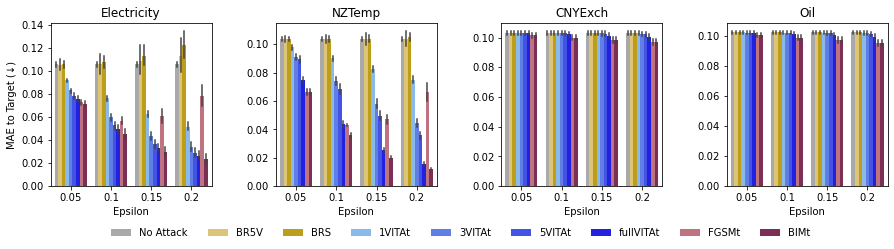

In [42]:
import matplotlib.ticker as mtick
f, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=False)
for i, ds in enumerate(all_d_names):
    g = sns.barplot(palette=cdict, hue_order=order_t_anns, ax=ax[i], errwidth=1.5,
                 data=df_t_anns_grouped.loc[df_t_anns_grouped['df'] == ds], hue='Attack Name', y='Attacked AE', x='Epsilon')
    g.legend_.remove()
    g.set(ylabel="MAE to Target (↓)")
    g.set(title=ds)
    if i==2:
        g.legend(loc='upper center', bbox_to_anchor=(-0.25, -0.2), frameon=False, ncol=9)
    if i>0:
        g.set(ylabel=None)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.savefig('tar_epsilon_vs_MAE_group_by_dataset.pdf', bbox_inches='tight')

f, ax = plt.subplots(5, 4, figsize=(10, 8), sharey=False, sharex=False)
for j, d in enumerate(df_grouped['Dataset'].unique()):
    for i, m in enumerate(['CNN', 'LSTM', 'RNN', 'GRU']):
        print(i%2+j+i//2, i//2)
        g = sns.scatterplot(palette=cdict, hue_order=order_t, ax=ax[j, i], 
                            data=df_grouped.loc[(df_grouped['Model'] == m) & (df_grouped['Dataset'] == d)], x='Total Perturbation', y='AE', hue='Attack')
        x_range = g.get_xlim()[1] - g.get_xlim()[0]
        y_range = g.get_ylim()[1] - g.get_ylim()[0]

        g.axvline(x=g.get_xlim()[0]+x_range/2, color="black", linestyle="--")
        g.axhline(y=g.get_ylim()[0]+y_range/2, color="black", linestyle="--")
        g.text(g.get_xlim()[0]+0.8*x_range/4, g.get_ylim()[0]+y_range/4, "LPLR", fontsize=10)
        g.text(g.get_xlim()[1]-1.2*x_range/4, g.get_ylim()[0]+y_range/4, "HPLR", fontsize=10)
        g.text(g.get_xlim()[0]+0.8*x_range/4, g.get_ylim()[1]-y_range/4, "LPHR", fontsize=10)
        g.text(g.get_xlim()[1]-1.2*x_range/4, g.get_ylim()[1]-y_range/4, "HPHR", fontsize=10)
        if i%2==0: g.set(xticks=[], xlabel=None)
        g.set(title=m)
        g.set(ylabel="MAE")
        if i!=3 and j!= 5: 
            g.legend_.remove()
        else:
            g.legend(loc='upper center', bbox_to_anchor=(-0.18, -0.25), frameon=False, ncol=4)
plt.savefig('nont_total_perturbation_vs_MAE_group_by_model.pdf', bbox_inches='tight')

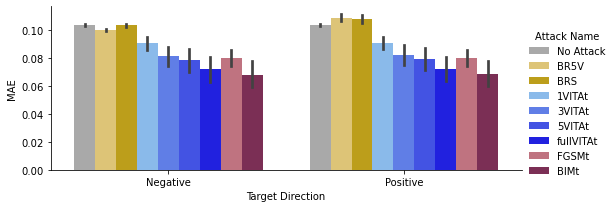

In [43]:
sns.catplot(kind='bar', height=3, aspect=2.5, palette=cdict, hue_order=order_t_anns,
            data=df_t_anns_grouped, hue='Attack Name', y='Attacked AE', x='Target Direction')
plt.ylabel("MAE")
plt.savefig('tar_target_vs_MAE.pdf', bbox_inches='tight')

In [44]:
df_t_anns_no_base_grouped = df_t_anns_grouped[df_t_anns_grouped["Attack Name"].isin(order_t_anns[3:])]

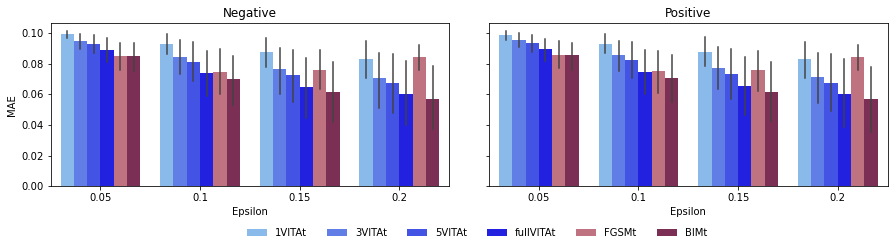

In [45]:
import matplotlib.ticker as mtick
f, ax = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
for i, ds in enumerate(df_t_anns_no_base_grouped['Target Direction'].unique()):
    g = sns.barplot(palette=cdict, hue_order=order_t_anns[3:], ax=ax[i], errwidth=1.5,
                 data=df_t_anns_no_base_grouped.loc[df_t_anns_no_base_grouped['Target Direction'] == ds], hue='Attack Name', y='Attacked AE', x='Epsilon')
    g.legend_.remove()
    #g.set(xlabel=None, xticks=[])
    g.set(ylabel="MAE")
    g.set(title=ds)
    if i==1:
        g.legend(loc='upper center', bbox_to_anchor=(-0.03, -0.2), frameon=False, ncol=6)
    if i>0:
        g.set(ylabel=None)
           
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
plt.savefig('tar_epsilon_vs_MAE_group_by_target.pdf', bbox_inches='tight')

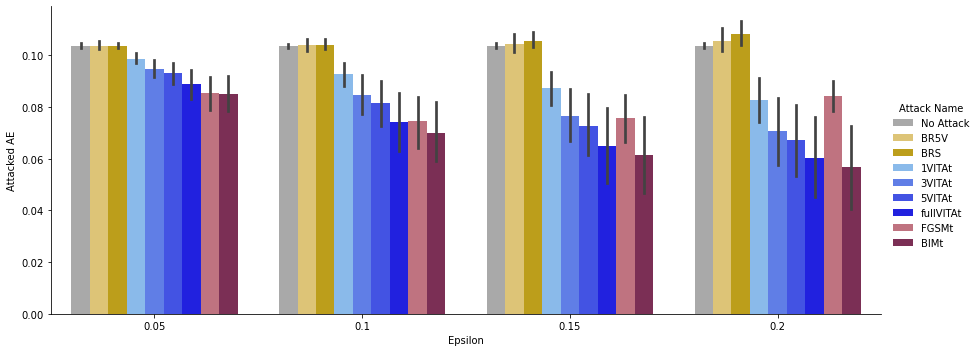

In [46]:
sns.catplot(kind='bar', aspect=2.5, palette=cdict, hue_order=order_t_anns,
            data=df_t_anns_grouped, hue='Attack Name', y='Attacked AE', x='Epsilon')

## Tar CD plots

In [47]:
df_t_anns_grouped

,df,Model,Attack Name,Epsilon,Target Direction,Total Perturbation,Max Perturbation,Attacked AE
0,CNYExch,CNN,1VITAt,0.05,Negative,0.000762,0.000762,0.100857
1,CNYExch,CNN,1VITAt,0.05,Positive,0.000762,0.000762,0.100877
2,CNYExch,CNN,1VITAt,0.10,Negative,0.001791,0.001791,0.100733
3,CNYExch,CNN,1VITAt,0.10,Positive,0.001810,0.001810,0.100745
4,CNYExch,CNN,1VITAt,0.15,Negative,0.002927,0.002927,0.100567
...,...,...,...,...,...,...,...,...
859,Oil,LSTM,fullVITAt,0.10,Positive,0.062206,0.005995,0.102015
860,Oil,LSTM,fullVITAt,0.15,Negative,0.096009,0.009005,0.101267
861,Oil,LSTM,fullVITAt,0.15,Positive,0.094721,0.008788,0.101345
862,Oil,LSTM,fullVITAt,0.20,Negative,0.127776,0.012019,0.100504


In [48]:
df_t_anns

,df,Seed,Model,Epsilon,Target Direction,Test Index,Attack Name,Attacked AE,Max Perturbation,Total Perturbation,Cost Time
0,Electricity,2210,CNN,0.05,Positive,0,No Attack,0.101838,0.000000,0.000000,0.000001
1,Electricity,2210,CNN,0.05,Positive,1,No Attack,0.101925,0.000000,0.000000,0.000005
2,Electricity,2210,CNN,0.05,Positive,2,No Attack,0.100922,0.000000,0.000000,0.000004
3,Electricity,2210,CNN,0.05,Positive,3,No Attack,0.101889,0.000000,0.000000,0.000004
4,Electricity,2210,CNN,0.05,Positive,4,No Attack,0.102438,0.000000,0.000000,0.000015
...,...,...,...,...,...,...,...,...,...,...,...
543295,Oil,1111111,GRU,0.20,Negative,95,fullVITAt,0.102741,0.002903,0.055521,0.831343
543296,Oil,1111111,GRU,0.20,Negative,96,fullVITAt,0.102849,0.001626,0.029471,4.205502
543297,Oil,1111111,GRU,0.20,Negative,97,fullVITAt,0.105170,0.005270,0.070274,188.870213
543298,Oil,1111111,GRU,0.20,Negative,98,fullVITAt,0.101597,0.005518,0.112222,702.146734


In [49]:
t_df_g = copy.deepcopy(df_t_anns[["df", "Seed", "Model","Test Index", "Attack Name", "Epsilon", "Target Direction", "Attacked AE"]])
t_df_g.columns = ['Dataset','Seed', 'Model', 'Window Index', 'Attack', 'Epsilon', 'Target', 'AE']

In [50]:
t_df_g_all = copy.deepcopy(t_df_g)

t_df_g_all = t_df_g_all.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index', 'Target'], 
        columns="Attack",
        values="AE")
t_df_g_all.isnull().values.any() 

False

In [51]:
targeted_result_all = autorank.autorank(t_df_g_all, alpha=0.05, verbose=False, order='ascending')
print(targeted_result_all)

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


RankResult(rankdf=
           meanrank    median       mad  ci_lower  ci_upper effect_size  \
Attack                                                                    
BIMt       1.609708  0.091321  0.011311  0.090379  0.092174         0.0   
FGSMt      2.320750  0.094446  0.008585  0.093909  0.094917   -0.209899   
fullVITAt  3.525812  0.096621  0.007751  0.095862  0.097236   -0.368671   
5VITAt     4.844313  0.099709  0.005002  0.099541  0.099844   -0.646971   
3VITAt     5.339437  0.099922  0.004768  0.099804  0.100029   -0.668409   
1VITAt     6.222667  0.100345  0.003939  0.100278  0.100421   -0.718731   
BRS        6.830563  0.103014  0.003256  0.102921  0.103098   -0.947652   
BR5V       7.056250  0.103108  0.002532  0.103032  0.103178   -0.970021   
No Attack  7.250500  0.103398  0.001794  0.103342  0.103459   -1.005933   

            magnitude  
Attack                 
BIMt       negligible  
FGSMt           small  
fullVITAt       small  
5VITAt         medium  
3VITAt     

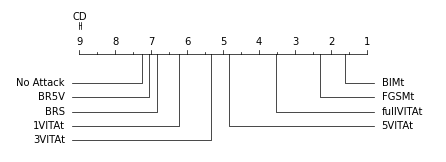

In [52]:
autorank.plot_stats(targeted_result_all)
#plt.title("the CD Diagram of the Untargeted Attack (All)")
plt.savefig("tar_cd_all.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


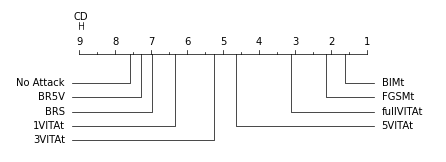

In [53]:
t_df_g_cnn = copy.deepcopy(t_df_g).loc[t_df_g['Model'] == "CNN"]

t_df_g_cnn = t_df_g_cnn.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index', 'Target'], 
        columns="Attack",
        values="AE")
print(t_df_g_cnn.isnull().values.any() )

targeted_result_cnn = autorank.autorank(t_df_g_cnn, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(targeted_result_cnn)
#plt.title("the CD Diagram of the Untargeted Attack (cnn)")
plt.savefig("tar_cd_cnn.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


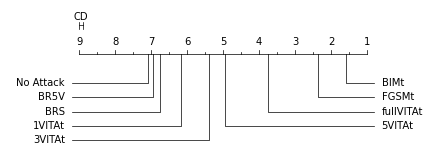

In [54]:
t_df_g_lstm = copy.deepcopy(t_df_g).loc[t_df_g['Model'] == "LSTM"]

t_df_g_lstm = t_df_g_lstm.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index', 'Target'], 
        columns="Attack",
        values="AE")
print(t_df_g_lstm.isnull().values.any() )

targeted_result_lstm = autorank.autorank(t_df_g_lstm, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(targeted_result_lstm)
#plt.title("the CD Diagram of the Untargeted Attack (lstm)")
plt.savefig("tar_cd_lstm.pdf", bbox_inches='tight')
plt.show()

False


D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


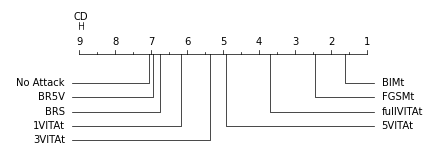

In [55]:
t_df_g_gru = copy.deepcopy(t_df_g).loc[t_df_g['Model'] == "GRU"]

t_df_g_gru = t_df_g_gru.pivot(index=['Dataset','Seed','Model','Epsilon','Window Index', 'Target'], 
        columns="Attack",
        values="AE")
print(t_df_g_gru.isnull().values.any() )

targeted_result_gru = autorank.autorank(t_df_g_gru, alpha=0.05, verbose=False, order='ascending')

autorank.plot_stats(targeted_result_gru)
#plt.title("the CD Diagram of the Untargeted Attack (gru)")
plt.savefig("tar_cd_gru.pdf", bbox_inches='tight')
plt.show()

In [56]:
tar_df_g_models = copy.deepcopy(t_df_g)
tar_df_g_models.columns = ['Dataset','Seed', 'Model', 'Window Index', 'Attack', 'Epsilon', 'Target', 'AE']
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == 'No Attack'].index)

tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == 'BRS'].index)
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == 'BR5V'].index)
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == '1VITAt'].index)
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == '3VITAt'].index)
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == '5VITAt'].index)
tar_df_g_models = tar_df_g_models.drop(tar_df_g_models[tar_df_g_models.Attack == 'FGSMt'].index)

tar_df_g_models = tar_df_g_models.pivot(index=['Dataset','Seed', 'Epsilon','Window Index', 'Target'], 
        columns=['Model', 'Attack'],
        values="AE")
tar_df_g_models.isnull().values.any() 

False

In [57]:
targeted_result_models = autorank.autorank(tar_df_g_models, alpha=0.05, verbose=False, order='ascending')
print(targeted_result_models)

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


RankResult(rankdf=
                 meanrank    median       mad  ci_lower  ci_upper effect_size  \
Model Attack                                                                    
CNN   BIMt       1.897687  0.088986  0.010323  0.087802  0.090073         0.0   
LSTM  BIMt       2.922125  0.093761   0.00901  0.092252  0.095062   -0.332385   
CNN   fullVITAt  2.968625  0.094071  0.006568   0.09292  0.095044    -0.39644   
GRU   BIMt       3.476500  0.092927  0.010949  0.090764  0.094551    -0.24983   
LSTM  fullVITAt  4.642563  0.099186  0.005152  0.098077   0.10001   -0.843335   
GRU   fullVITAt  5.092500  0.098759  0.006598  0.097174  0.099892   -0.760857   

                  magnitude  
Model Attack                 
CNN   BIMt       negligible  
LSTM  BIMt            small  
CNN   fullVITAt       small  
GRU   BIMt            small  
LSTM  fullVITAt       large  
GRU   fullVITAt      medium  
pvalue=0.0
cd=0.05960509953833893
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_sh

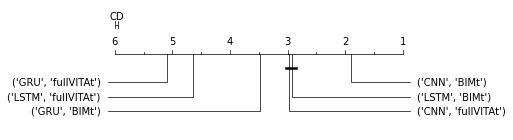

In [58]:
autorank.plot_stats(targeted_result_models)
plt.savefig("tar_cd_models_with_the_best_two.pdf", bbox_inches='tight')
plt.show()

### Targeted Random Forest

In [59]:
df_t_all4_no_base = df_t_all4[df_t_all4["Attack Name"].isin(order_t_anns[3:])]

df_t_all4_no_base_grouped = df_t_all4_no_base.groupby(['df', 'Model', 'Attack Name', 'Epsilon', 'Target Direction'], as_index=False)

df_t_all4_no_base_grouped = df_t_all4_no_base_grouped.agg(
    {'Total Perturbation':'mean', 'Max Perturbation':'mean', 'Attacked AE':'mean'})
#df_grouped = df_grouped[~df_grouped['Attack Name'].isin(['RFGSM', 'BPM', 'BNM'])]

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which 

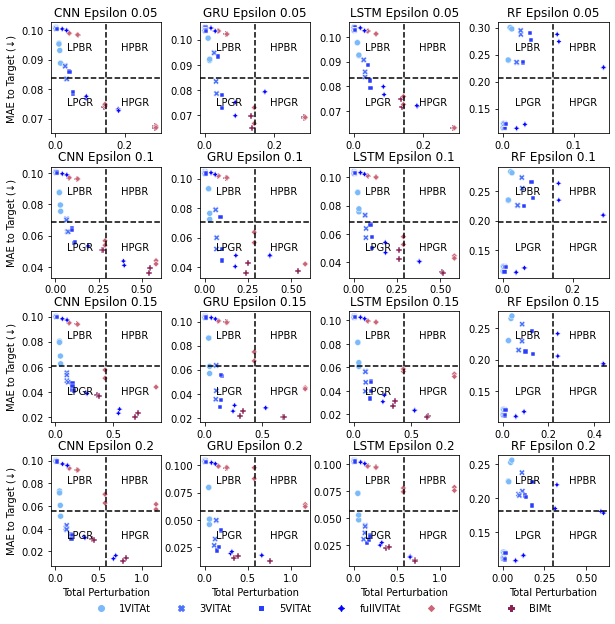

In [60]:
f, ax = plt.subplots(4, 4, figsize=(10, 10), sharey=False, sharex=False)
for i, m in enumerate(df_t_all4_no_base_grouped['Epsilon'].unique()):
    df_models = df_t_all4_no_base_grouped.loc[df_t_all4_no_base_grouped['Epsilon'] == m].copy()
                            
    for j, n in enumerate(df_t_all4_no_base_grouped['Model'].unique()):
        df = df_models.loc[df_models['Model'] == n].copy()
        g = sns.scatterplot(palette=cdict, hue_order=order_t_anns[3:], ax=ax[i, j], 
                            data=df, x='Total Perturbation', y='Attacked AE', hue='Attack Name', style="Attack Name",style_order=df_t_all4_no_base_grouped['Attack Name'].unique().tolist())
        
        x_range = g.get_xlim()[1] - g.get_xlim()[0]
        y_range = g.get_ylim()[1] - g.get_ylim()[0]

        g.axvline(x=g.get_xlim()[0]+x_range/2, color="black", linestyle="--")
        g.axhline(y=g.get_ylim()[0]+y_range/2, color="black", linestyle="--")
        g.text(g.get_xlim()[0]+0.6*x_range/4, g.get_ylim()[0]+y_range/4, "LPGR", fontsize=10)
        g.text(g.get_xlim()[1]-1.45*x_range/4, g.get_ylim()[0]+y_range/4, "HPGR", fontsize=10)
        g.text(g.get_xlim()[0]+0.6*x_range/4, g.get_ylim()[1]-y_range/4, "LPBR", fontsize=10)
        g.text(g.get_xlim()[1]-1.45*x_range/4, g.get_ylim()[1]-y_range/4, "HPBR", fontsize=10)
        
        if i!=3: g.set(xlabel=None)
        g.set(title=str(n)+" Epsilon "+str(m))
        if j==0: 
            g.set(ylabel="MAE to Target (↓)")
        else:
            g.set(ylabel=None)
        if i==3 and j==1: 
            g.legend(loc='upper center', bbox_to_anchor=(1.1, -0.25), frameon=False, ncol=8)
        else:
            g.legend_.remove()
            
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.3)
plt.savefig('tar_total_perturbation_vs_MAE_group_by_epsilon_and_model.pdf', bbox_inches='tight')

# Plot: Sliding Windows

In [61]:
X = np.array([0.46, 0.52, 0.44, 0.58, 0.54, 0.41, 0.49, 0.55, 0.51, 0.52, 0.62, 0.45, 0.57, 0.48, 0.61])
num = 15

In [62]:
from matplotlib import colors
#cmap = cm.get_cmap('Blues')
#cmap = colors.LinearSegmentedColormap.from_list("", ["lightskyblue","purple"])
cmap = colors.LinearSegmentedColormap.from_list("", ["lightskyblue","blue"])

In [63]:
# Source: https://stackoverflow.com/questions/31908982/python-matplotlib-multi-color-legend-entry

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

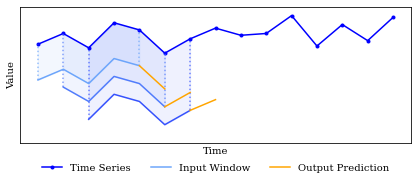

In [64]:
num_windows = 3
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
f, ax = plt.subplots(figsize=(7,2.5))
plt.plot(range(len(X[:num])), X[:num], c='blue', label='Time Series', marker='.')
plt.ylim([np.min(X[:num])-0.1*num_windows-0.2, np.max(X[:num])+0.05])
colors = []
for i in range(num_windows):#range(len(X[:num])-4):
    col = cmap((i+1) / (num_windows+2))
    colors.append(col)
    plt.plot(range(i, i+5), X[i:i+5]-(i+2)*0.1, c=col, zorder=3, label=('Input Window' if i==0 else ''))
    plt.plot(range(i+4, i+6), X[i+4:i+6]-(i+2)*0.1, c='orange', label=('Output Prediction' if i==0 else ''), zorder=3)
    plt.fill_between(range(i, i+5), X[i:i+5]-(i+2)*0.1, X[i:i+5], alpha=0.08, color=col)
    plt.vlines(x=i, ymin=X[i]-(i+2)*0.1, ymax=X[i], linestyles=':', colors=col, alpha=0.7)
    plt.vlines(x=i+4, ymin=X[i+4]-(i+2)*0.1, ymax=X[i+4], linestyles=':', colors=col, alpha=0.7)
plt.yticks([])
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
h, l = ax.get_legend_handles_labels()
h.append(MulticolorPatch(colors))
#l.append('Walk-forwad Windows')
plt.legend(h, l, loc='upper center', 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, bbox_to_anchor=(0.5, -0.09), frameon=False, ncol=4)
#f.text(0.4,0.55, "Window 1", fontsize=8)
#f.text(0.47,0.425, "Window 2", fontsize=8)
#f.text(0.53,0.3, "Window 3", fontsize=8)
plt.savefig('sliding_windows.pdf', bbox_inches='tight')